Repeat of the experiment done in 

**Learning long-term dependencies with gradient descent is difficult**

https://dl.acm.org/citation.cfm?id=2328340

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mlp

mlp.style.use('classic')

%matplotlib inline

In [2]:
import numpy as np

from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.layers import Input, LSTM, LSTMCell, Dense, SimpleRNN
from keras.utils.vis_utils import plot_model
from keras import backend as K

/projects/btl2/zxue/miniconda3/envs/venv-tf-cpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [4]:
seq_len = 5
N = 10000
batch_size = 100

xs = np.zeros((N, seq_len))
ys = np.zeros(N)

# construct input data
positive_indexes = np.arange(N // 2)
negative_indexes = np.arange(N // 2, N)

xs[positive_indexes, 0] = 1
ys[positive_indexes] = 1

xs[negative_indexes, 0] = -1
ys[negative_indexes] = 0

noise = np.random.normal(loc=0, scale=0.1, size=(N, seq_len))

train_xs = (xs + noise).reshape(N, seq_len, 1)
train_ys = ys

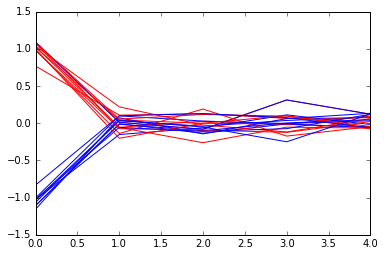

In [5]:
for i in range(10):
    plt.plot(train_xs[i], color='red')
    plt.plot(train_xs[-i], color='blue')

In [6]:
inputs = Input(shape=(None, 1), name='input')
# rnn = LSTM(1, input_shape=(None, 1), name='rnn')
rnn = SimpleRNN(1, input_shape=(None, 1), name='rnn')
rnn_out = rnn(inputs)
# dense = Dense(2, activation='softmax', name='output')
dense = Dense(1, activation='sigmoid', name='output')
# dense = Dense(1, activation='relu', name='output')
dense_out = dense(rnn_out)
model = Model(inputs, dense_out)
# optm = Adam(lr=1e-5)
optm = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optm, loss='mse', metrics=['accuracy'])
hist = model.fit(train_xs, train_ys,
                 batch_size=batch_size,
                 epochs=20,
                 validation_split=0.2, 
                 verbose=0)

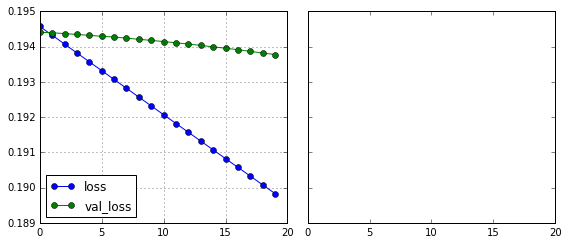

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3.5))
axes = axes.ravel()

for k, keys in enumerate([['loss', 'val_loss']]):
    ax = axes[k]
    
    for key in keys:
        ax.plot(hist.history[key], 'o-', label=key)
    ax.grid()
    ax.legend(loc='best')
plt.tight_layout()

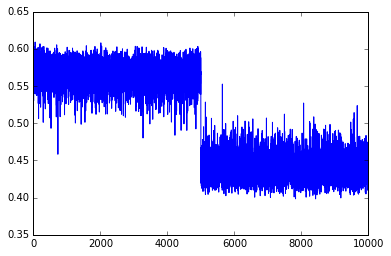

In [8]:
# the positive and negative only vary by a small difference considering output from sigmoid
plt.plot(model.predict(train_xs))

In [9]:
wx = rnn.get_weights()[0].ravel()[0]
wh = rnn.get_weights()[1].ravel()[0]
bias = rnn.get_weights()[2].ravel()[0]
print(wx, wh, bias)

1.3012989 1.0199174 0.0077716387


In [10]:
d_w0 = dense.get_weights()[0][0]
d_b0 = dense.get_weights()[1]
print(d_w0, d_b0)

[0.5258578] [0.00839327]


[0.59750193] [[0.597502]]
[0.5635444] [[0.5635444]]
[0.42233437] [[0.42233437]]
[0.44944862] [[0.44944862]]


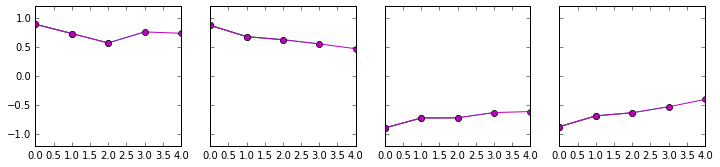

In [11]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 2.5))
axes = axes.ravel()

for k, single_x in enumerate([train_xs[0], train_xs[1], train_xs[-2], train_xs[-1]]):
    ax = axes[k]
    h_prev = 0
    hist = []
    for t in range(single_x.shape[0]):
        cat_x = [h_prev, single_x[t][0]]
        _out = np.tanh(np.dot([wh, wx], cat_x) + bias)
        hist.append(_out)
        h_prev = _out
        ax.plot(hist, 'o-')
    den_in = hist[-1]
    out = sigmoid(den_in * d_w0 + d_b0)
    # mannually calculated output should match that of the model prediction, 
    # so that it means the mannual process is correct
    print(out, model.predict(np.array([single_x])))
    ax.set_ylim(-1.2, 1.2)